# Quick step by step guide through the traffic light detection process

1) Download the training data provided by Shyam Jagannathan 
https://drive.google.com/drive/folders/0Bz-TOGv42ojzOHhpaXJFdjdfZTA

2) Copy training files into CarND-Capstone/ros/src/tl_detector/training/data_sim/ 

Import dependencies

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import numpy as np
import cv2
import keras as K

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

# set this session as Keras Session
K.backend.set_session(tf.Session(config=tf_config))

Using TensorFlow backend.


In [2]:
def read_record_file(filname : str):
    '''
    Convert record file to list of images with their bounding boxes 
    :param filname: 
    :return: 
    '''

    record_iterator = tf.python_io.tf_record_iterator(filname)

    records = []
    for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)

        height = int(example.features.feature['image/height']
                     .int64_list
                     .value[0])

        width = int(example.features.feature['image/width']
                    .int64_list
                    .value[0])

        img_string = (example.features.feature['image/encoded']
                                      .bytes_list
                                      .value[0])

        bbox_xmin = np.array(example.features.feature['image/object/bbox/xmin'].float_list.value) * width
        bbox_xmax = np.array(example.features.feature['image/object/bbox/xmax'].float_list.value) * width
        bbox_ymin = np.array(example.features.feature['image/object/bbox/ymin'].float_list.value) * height
        bbox_ymax = np.array(example.features.feature['image/object/bbox/ymax'].float_list.value) * height

        class_text = np.array(example.features.feature['image/object/class/text'].bytes_list.value)
        class_label = np.array(example.features.feature['image/object/class/label'].int64_list.value)

        img_1d = np.fromstring(img_string, dtype=np.uint8)
        img = cv2.imdecode(img_1d,-1)

        records.append([img, bbox_xmin, bbox_xmax, bbox_ymin, bbox_ymax, class_text, class_label])

    return records

In [3]:
def draw_rect(img, xmin, xmax, ymin , ymax, id):
    '''
    Helper function to draw a rectangle 
    :param img: 
    :param xmin: 
    :param xmax: 
    :param ymin: 
    :param ymax: 
    :param id: 
    :return: 
    '''

    color = (0, 0, 0)
    if id == 1:  # red
        color = (0, 0, 255)
    elif id == 2:  # yellow
        color = (0, 255, 255)
    elif id == 3:  # green
        color = (0, 255, 0)

    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 3)

In [42]:
def perform_inference(detection_graph, example_records,score_threshold=0.5):
    '''
    for each record perform inference and draw results
    :param detection_graph: 
    :param example_records: 
    :param score_threshold: 
    :return: 
    '''

    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            for idx, record in enumerate(example_records):

                img = record[0]

                in_image_height = img.shape[0]
                in_image_width = img.shape[1]

                image_with_prediction = np.copy(img)
                image_np_expanded = np.expand_dims(image_with_prediction, axis=0)

                xmins, xmaxs, ymins, ymaxs, texts, labels = record[1:]

                for xmin, xmax, ymin, ymax, text, label in zip(xmins, xmaxs, ymins, ymaxs, texts, labels):
                    draw_rect(img, xmin, xmax, ymin, ymax, label)

                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})

                for box, score, id in zip(boxes[0], scores[0], classes[0]):
                    if score > score_threshold:
                        ymin, xmin, ymax, xmax = box

                        ymin = int(ymin * in_image_height)
                        ymax = int(ymax * in_image_height)

                        xmin = int(xmin * in_image_width)
                        xmax = int(xmax * in_image_width)

                        draw_rect(image_with_prediction, xmin, xmax, ymin, ymax, id)

                yield img, image_with_prediction

## Training

To train a new model:

Copy https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md -> ssd_mobilenet_v1_coco into CarND-Capstone/ros/src/tl_detector/training/model/ssd_mobilenet/ckpt/

1. Tensorboard
tensorboard --logdir=model/eval/ --port=6006 

2. start train script
python object_detection/train.py --logtostderr --pipeline_config_path=pipeline_ssd_v1_sim.config --train_dir=model/train/ 


3. start eval script 
python object_detection/eval.py --logtostderr --pipeline_config_path=pipeline_ssd_v1_sim.config --checkpoint_dir=model_sim/train/ --eval_dir=model_sim/eval/ 

4. compile model 
python object_detection/export_inference_graph.py --input_type image_tensor --pipeline_config_path=pipeline_ssd_v1_sim.config --trained_checkpoint_prefix=model_sim/train/model.ckpt-1000 --output_directory=model_sim/train/inference







Paths to the model and record file

In [11]:
tfrecords_filename = "/data/Datasets/TrafficLightRecords/traffic-light-sim-test.record"
inference_path = "/home/c.marzahl@de.eu.local/SelfDrivingCar/CarND-Capstone/ros/src/tl_detector/training/model_sim/inference/frozen_inference_graph.pb"

In [12]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()

    with tf.gfile.GFile(inference_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')Load records and inference graph 

In [46]:
records = read_record_file(tfrecords_filename)


red_traffic_lights = [record for record in records if b'red' in record[5]]
np.random.shuffle(red_traffic_lights)
yellow_traffic_lights = [record for record in records if b'yellow' in record[5]]
np.random.shuffle(yellow_traffic_lights)
green_traffic_lights = [record for record in records if b'green' in record[5]]
np.random.shuffle(green_traffic_lights)

example_records = []
example_records.extend(red_traffic_lights[:3])
example_records.extend(yellow_traffic_lights[:3])
example_records.extend(green_traffic_lights[:3])

Show results on test images

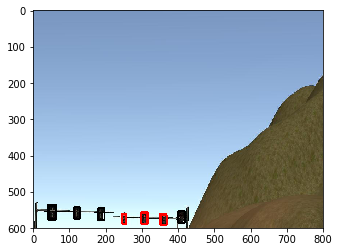

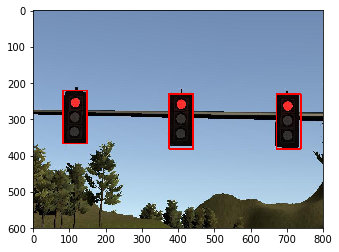

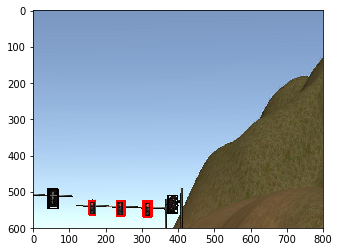

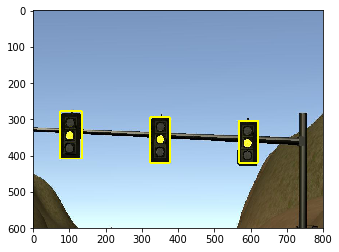

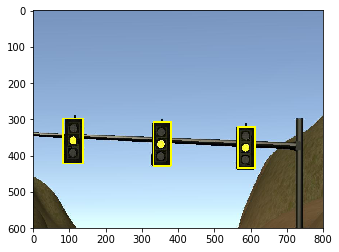

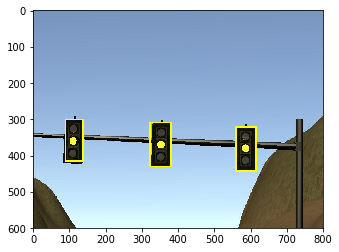

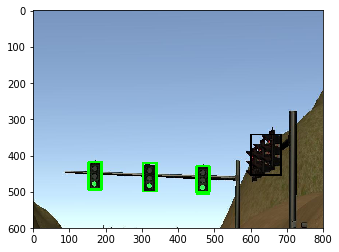

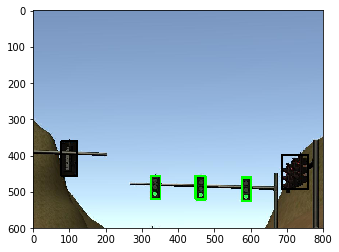

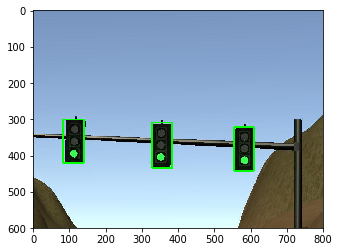

In [56]:
for img, image_with_prediction in perform_inference(detection_graph, example_records, 0.6):
 
    result = cv2.cvtColor(image_with_prediction, cv2.COLOR_BGR2RGB) #COLOR_BGR2RGB  #COLOR_RGB2BGR
    plt.figure()
    plt.imshow(result)